# Exploring Data in SCOOT and FLOW
*Comparing count data in SCOOT and FLOW; only weekday counts used.*

In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from pg import DB
import configparser
import numpy as np
import preprocess
import plotting_functions
from collections import OrderedDict
from sklearn import linear_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DB Setup and Global Parameters

In [24]:
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
db = DB(dbname=dbset['database'],host=dbset['host'],user=dbset['user'],passwd=dbset['password'])

In [25]:
# Lakeshore (Ontario to Rees) SCN#
corridor = [30311, 30321, 30411, 30421, 30431, 30451, 30511]
corridor_tcl = [str(x) for x in [1147466,1147283,14255078,30020765,12347485,1147201,8491741,13973647,30082914,1147026]]
seg_names = ['Ontario Pl - Stranchan','Strachan - Fort York','Stranchan - Fort York','Fort York - Remembrance',
             'Remembrance - Stadium','Stadium - Bathurst','Bathurst - Dan Leckie','Bathurst - Dan Leckie','Dan Leckie - Spadina',
             'Spadina - Rees']
# Don Mills (Eglinton to Lawrence) SCN#
#corridor = [70211, 12881, 12871, 12861, 12851, 12821]

## SCOOT Setup
Query detector and mapping information from database

In [26]:
# Get list of all detectors
sdetectors = pd.DataFrame(db.query('SELECT scn,px,det,direction,sideofint FROM scoot.scoot_detectors').getresult(),columns=['scn','px','det','direction','sideofint'])
# Filter out detectors not along the specified corridor
sdetectors = sdetectors[sdetectors['scn'].isin(corridor)]
# Filter out turning movement detectors
sdetectors = sdetectors[sdetectors.direction.str.contains("LT")==False]
# Get mapping of the detectors 
sdet_tcl = pd.DataFrame(db.query('SELECT detector, centreline_id FROM scoot.detector_tcl').getresult(),columns=['det','centreline_id'])
# Merge mapping to detectors dataframe
sdetectors = sdetectors.merge(sdet_tcl, how='inner')
# Reformat detector names to match those of raw input tables
sdetectors['det'] = ['N'+x for x in list(sdetectors['det'])]
# Filter out legs that are perpendicular to the corridor
sdetectors = sdetectors[(sdetectors['direction']=='EB') | (sdetectors['direction']=='WB')]
# Filter out individual detectors (in this case, because they are measuring fleet st)
sdetectors = sdetectors[(sdetectors['det']!='N30421X1') & (sdetectors['det']!='N30421Z1') & (sdetectors['det']!='N30331B1') & (sdetectors['det']!='N30411H1') & (sdetectors['det']!='N30431T1')]

## Time of Day Profile
Time of day profile plots are produced for data within a specified time period using start_year, start_month, end_year, and end_month. For each location, two plots are placed side by side. The left one is 15 min volume normalized by total daily volume. The one on the right is actual volumes detected. Average profile of the time period in scope is plotted with thick lines.

 * Missing values are filled in by interpolation. Missing values at the beginning or the end are filled with the value immediately after/before.
 * Only days with more than 2/3 counted bins (64 15min observations) are plotted and taken into average calculation. Days with less than 64 observations are discarded for this purpose.

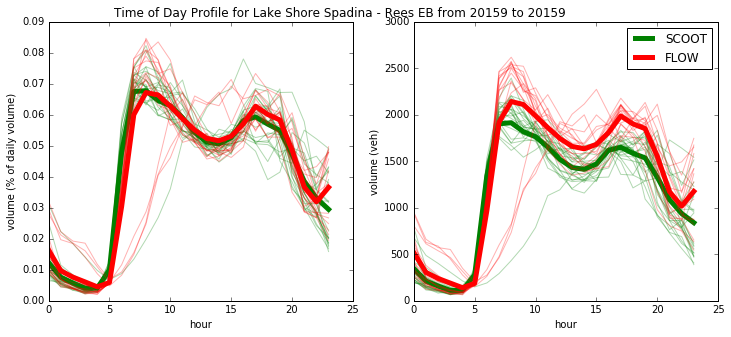

In [27]:
# SCOOT 
nc = []
start_year = 2015
start_month = 9
end_year = 2015    
end_month = 9
end_day = 30
gs = [(1147026,'EB')]
colorss = ['g','y','b','k']

for g in gs:
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,5))
    plt.title('Time of Day Profile for Lake Shore ' + seg_names[corridor_tcl.index(str(g[0]))] + ' '+ str(g[1]) + ' from ' + str(start_year) + str(start_month) + ' to '+ str(end_year) + str(end_month),ha='right',va='baseline')
    for year in range(start_year, end_year+1):
        (sm,em) = preprocess.get_start_end_month(start_year, end_year, start_month, end_month, year)
        for month in range(sm, em):
            if month < 10:
                m = '0' + str(month)
            else:
                m = str(month)
            # Read in Raw Data
            #sdata = pd.DataFrame(db.query('SELECT detector, start_time, end_time, flow_mean FROM scoot.raw_'+str(year)+m).getresult(),columns=['detector', 'start_time', 'end_time', 'flow_mean'])        
            sdata = pd.read_table('DETS_'+str(year)+m+'.txt', delim_whitespace=True, skiprows=9, header = None, 
                                  names=['Site','DOW','Date','Time_Start','Time_End','flow_mean_veh/h'], usecols=range(6))
            sdata = preprocess.preprocess_scoot(sdata,sdetectors)

            # Plot TOD
            sncounts, savg, sndays = plotting_functions.TOD(ax1,sdata,'centreline_id','direction','Date','flow_mean_veh/h',g,colorss,True,'SCOOT')
            sncounts, savg, sndays = plotting_functions.TOD(ax2,sdata,'centreline_id','direction','Date','flow_mean_veh/h',g,colorss,False,'SCOOT')
            nc = nc+sncounts
'''        
# Plot availability
nc = pd.DataFrame(nc, columns=['date','ncount'])
nc['date'] = nc['date'].astype(str)
nc['date'] = pd.to_datetime(nc['date']).dt.date

fig = plt.subplots(figsize = [30,10])
plt.plot(nc['date'],nc['ncount'])
plt.grid()
'''

# FLOW
fdata = pd.DataFrame(db.query('SELECT centreline_id, count_bin, volume, dir_bin FROM prj_volume.centreline_volumes \
        WHERE centreline_id in (' + ','.join(corridor_tcl) + ') AND count_bin >= \'' + str(start_year) + '-' + \
        str(start_month) + '-01\' AND count_bin <= \'' + str(end_year) + '-' + str(end_month) + '-' + str(end_day) + '\'').getresult(), 
        columns = ['centreline_id','count_bin','volume','dir_bin'])
fdata = preprocess.preprocess_flow(fdata)
gf = [(1147026,+1)]
colorsf = ['r','p','o','c']
for g in gf:
    fncounts, favg, fndays = plotting_functions.TOD(ax1,fdata,'centreline_id','dir_bin','date','volume',g,colorsf,True,'FLOW')
    fncounts, favg, fndays = plotting_functions.TOD(ax2,fdata,'centreline_id','dir_bin','date','volume',g,colorsf,False,'FLOW')
plt.legend()
plt.show()

## Daily Volume
Total daily volume along a specified corridor in a specified time period is plotted. Each dot represents a day.

* Only days with more than 2/3 counted bins (64 15min observations) are plotted and taken into average calculation. Days with less than 64 observations are discarded for this purpose.
* Daily volume is calculated as total volume recorded/number of observations*96

Plotting Average Daily Volume from 20159 to 20159...


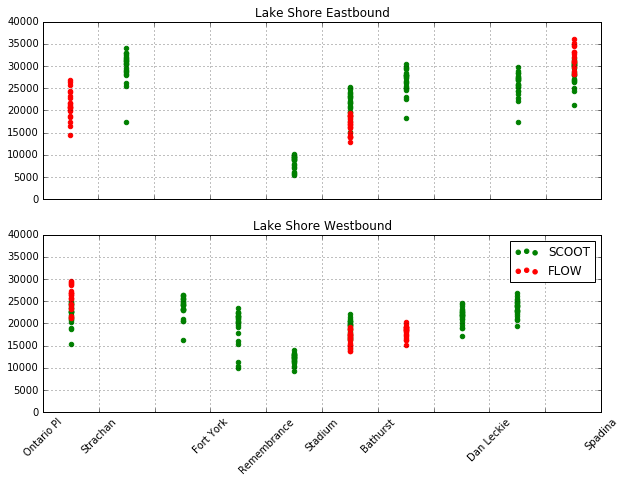

In [28]:
start_year = 2015
start_month = 9
end_year = 2015    
end_month = 9
end_day = 30

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,7), sharex = True, sharey = True)

# SCOOT 
colorss = ['g','y','b','k']
print('Plotting Average Daily Volume from ' + str(start_year) + str(start_month) + ' to '+ str(end_year) + str(end_month) + '...')
for year in range(start_year, end_year+1):
    (sm,em) = preprocess.get_start_end_month(start_year, end_year, start_month, end_month, year)
    for month in range(sm, em):
        if month < 10:
            m = '0' + str(month)
        else:
            m = str(month)
        # Read in Raw Data
        #sdata = pd.DataFrame(db.query('SELECT detector, start_time, end_time, flow_mean FROM scoot.raw_'+str(year)+m).getresult(),columns=['detector', 'start_time', 'end_time', 'flow_mean'])        
        sdata = pd.read_table('DETS_'+str(year)+m+'.txt', delim_whitespace=True, skiprows=9, header = None, 
                              names=['Site','DOW','Date','Time_Start','Time_End','flow_mean_veh/h'], usecols=range(6))
        sdata = preprocess.preprocess_scoot(sdata,sdetectors)
        
        plotting_functions.daily_vol(ax1,ax2,sdata,'stopindex','direction','Date','flow_mean_veh/h',colorss,'SCOOT')

# FLOW
fdata = pd.DataFrame(db.query('SELECT centreline_id, count_bin, volume, dir_bin FROM prj_volume.centreline_volumes \
        WHERE centreline_id in (' + ','.join(corridor_tcl) + ') AND count_bin >= \'' + str(start_year) + '-' + \
        str(start_month) + '-01\' AND count_bin <= \'' + str(end_year) + '-' + str(end_month) + '-' + str(end_day) + '\'').getresult(), 
        columns = ['centreline_id','count_bin','volume','dir_bin'])
fdata = preprocess.preprocess_flow(fdata)
colorsf = ['r','p','o','c']
plotting_functions.daily_vol(ax1,ax2,fdata,'stopindex','dir_bin','date','volume',colorsf,'FLOW')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

## Seasonality Plot
The plots explore seanonality trends in both data sources by plotting daily volume over a year at a specified location.

* Each dot represents a day
* Daily volume is calculated as that of the Daily Volume plots
* Different colors represents different months  

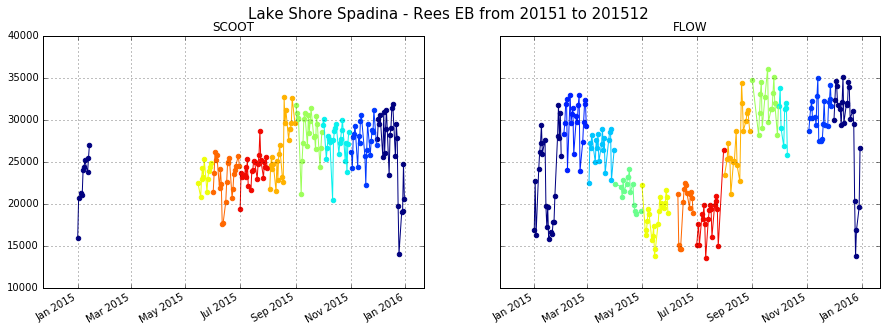

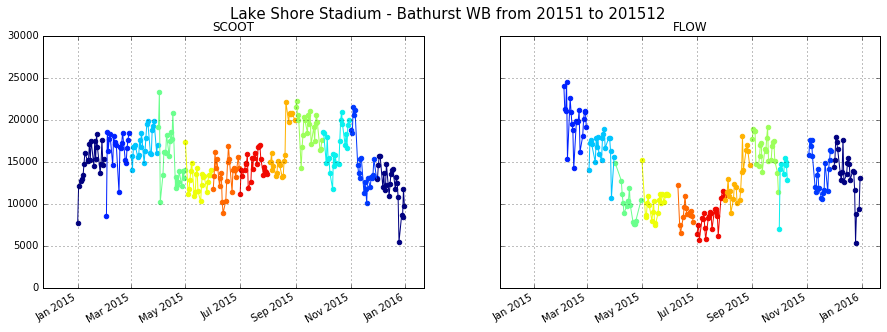

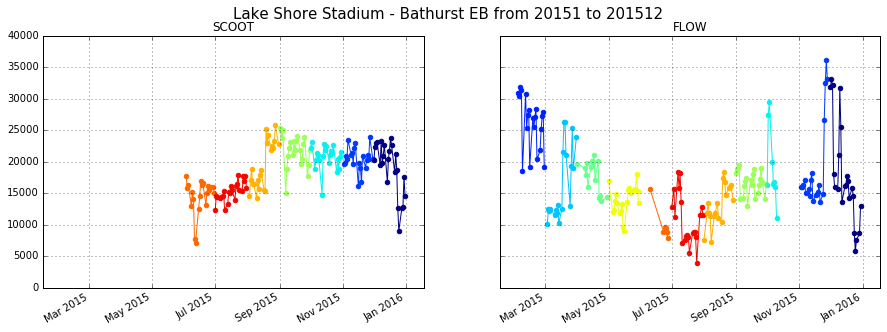

In [29]:
start_year = 2015
start_month = 1
end_year = 2015    
end_month = 12
end_day = 31
cm_subsection = np.append(np.linspace(0,0.8,6) ,np.linspace(0.9,0,6))
colors = [cm.jet(x) for x in cm_subsection]
gs = [(1147026,'EB'),(1147201,'WB'),(1147201,'EB')]
gf = [(1147026,+1),(1147201,-1),(1147201,+1)]

for g1, g2 in zip(gs, gf):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (15,5),sharey=True,sharex=True)
    ax1.set_title('SCOOT')
    ax2.set_title('FLOW')
    fig.suptitle('Lake Shore ' + seg_names[corridor_tcl.index(str(g1[0]))] + ' '+ str(g1[1]) + ' from ' + str(start_year) + str(start_month) + ' to '+ str(end_year) + str(end_month),fontsize=15)
    for year in range(start_year, end_year+1):
        (sm,em) = preprocess.get_start_end_month(start_year, end_year, start_month, end_month, year)
        for month in range(sm, em):
            if month < 10:
                m = '0' + str(month)
            else:
                m = str(month)
            # Read in Raw Data
            sdata = pd.read_table('DETS_'+str(year)+m+'.txt', delim_whitespace=True, skiprows=9, header = None, 
                                  names=['Site','DOW','Date','Time_Start','Time_End','flow_mean_veh/h','Occ_mean_%'], usecols=range(7))
            sdata = preprocess.preprocess_scoot(sdata,sdetectors)
            # Plot Seasonality
            plotting_functions.seasonality_plot(ax1,sdata,'centreline_id','direction','Date','flow_mean_veh/h',g1,colors)
    
    fdata = pd.DataFrame(db.query('SELECT centreline_id, count_bin, volume, dir_bin FROM prj_volume.centreline_volumes \
            WHERE centreline_id =' + str(g2[0]) + ' AND count_bin >= \'' + str(start_year) + '-' + \
            str(start_month) + '-01\' AND count_bin <= \'' + str(end_year) + '-' + str(end_month) + '-' + str(end_day) + '\'').getresult(), 
            columns = ['centreline_id','count_bin','volume','dir_bin'])
    fdata = preprocess.preprocess_flow(fdata)
    plotting_functions.seasonality_plot(ax2,fdata,'centreline_id','dir_bin','date','volume',g2,colors)

    fig.autofmt_xdate()
    plt.show()

## Point by Point Comparison
The plots aim to compare the disaggregate 15min observations. Each 15min where *both* FLOW and SCOOT have observations is plotted. FLOW volume on the x axis and SCOOT volume on the y axis. Table on the right presents linear regression results. 
* If a month is in the scope but not plotted (tabulated), either FLOW or SCOOT data is missing as a month is included if >10 common observations exist.

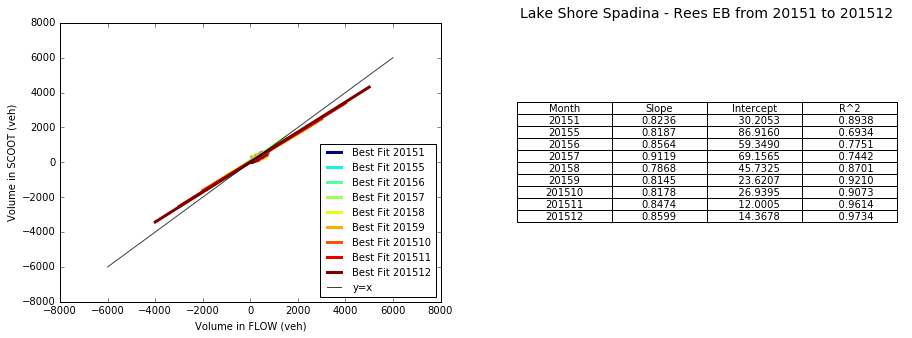

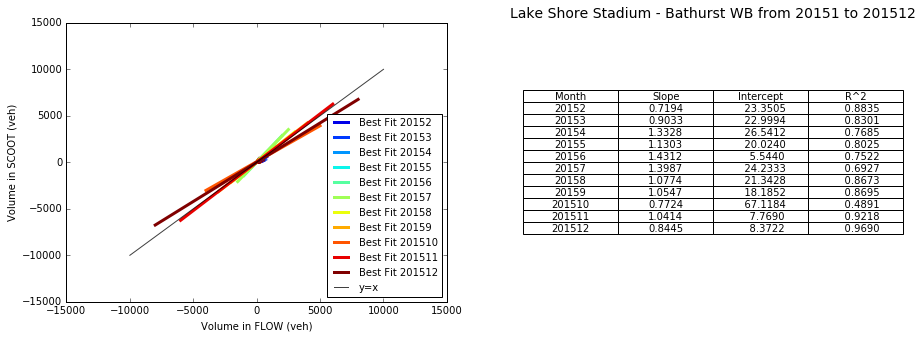

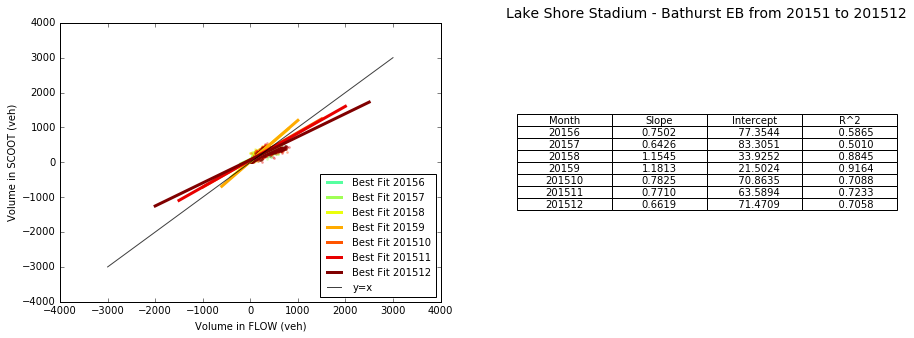

In [30]:
start_year = 2015
start_month = 1
end_year = 2015    
end_month = 12
end_day = 31

cm_subsection = np.linspace(0,1,12)
colors = [cm.jet(x) for x in cm_subsection]
gs = [(1147026,'EB'),(1147201,'WB'),(1147201,'EB')]
gf = [(1147026,+1),(1147201,-1),(1147201,+1)]

for g1, g2 in zip(gs, gf):  
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    ax2.axis('off')
    row=[]

    # FLOW
    fdata = pd.DataFrame(db.query('SELECT centreline_id, count_bin, volume, dir_bin FROM prj_volume.centreline_volumes \
            WHERE centreline_id = ' + str(g2[0]) + ' AND count_bin >= \'' + str(start_year) + '-' + \
            str(start_month) + '-01\' AND count_bin <= \'' + str(end_year) + '-' + str(end_month) + '-' + str(end_day) + '\' \
            AND dir_bin = ' + str(g2[1])).getresult(), 
            columns = ['centreline_id','count_bin','volume','dir_bin'])
    fdata = preprocess.preprocess_flow(fdata)
    # Sum if volume is stored on a lane by lane basis
    fdata = fdata.groupby(['month', 'time_15', 'date', 'centreline_id', 'stopindex', 'dir_bin', 'direction'], as_index=False).sum()
    regr = linear_model.LinearRegression()
    # SCOOT
    for year in range(start_year, end_year+1):
        (sm,em) = preprocess.get_start_end_month(start_year, end_year, start_month, end_month, year)
        for month in range(sm, em):
            if month < 10:
                m = '0' + str(month)
            else:
                m = str(month)
            
            # Read in Raw Data
            sdata = pd.read_table('DETS_'+str(year)+m+'.txt', delim_whitespace=True, skiprows=9, header = None, 
                                  names=['Site','DOW','Date','Time_Start','Time_End','flow_mean_veh/h','Occ_mean_%'], usecols=range(7))
            sdata = preprocess.preprocess_scoot(sdata,sdetectors)
            sdata = sdata.groupby(['Date','centreline_id','stopindex','month','time_15','direction'], as_index=False).sum()
            
            data = pd.merge(sdata, fdata, how = 'inner', left_on = ['Date','time_15','stopindex','direction'], right_on = ['date','time_15','stopindex','direction'])
            data = data[(data['volume']!=0) & (data['flow_mean_veh/h']!=0)]
            if len(data)>10:
                regr.fit(np.transpose(np.matrix(data['volume'])),np.transpose(np.matrix(data['flow_mean_veh/h'])))
                ax1.scatter(data['volume'], data['flow_mean_veh/h'], alpha = 0.3, color = colors[month-1], s = 3, label=None)
                xlim = ax1.get_xlim()
                x = np.transpose(np.matrix(np.linspace(xlim[0],xlim[1],10)))
                ax1.plot(x,regr.predict(x),color = colors[month-1],linewidth=3,label = 'Best Fit ' + str(year) + str(month))
                row.append([str(year)+str(month),"{:6.4f}".format(regr.coef_[0][0]), "{:10.4f}".format(regr.intercept_[0]), "{:10.4f}".format(regr.score(np.transpose(np.matrix(data['volume'])),np.transpose(np.matrix(data['flow_mean_veh/h']))))])

    ax2.table(cellText=row,colLabels=('Month','Slope','Intercept','R^2'), loc='center',cellLoc='center',fontsize=14)
                
    # Add y=x
    lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
    ]
    # plot both limits against eachother
    ax1.plot(lims, lims, 'k-', alpha=0.75, label = 'y=x')
    ax1.legend(loc=4,fontsize=10)
    plt.title('Lake Shore ' + seg_names[corridor_tcl.index(str(g1[0]))] + ' '+ str(g1[1]) + ' from ' + str(start_year) + str(start_month) + ' to '+ str(end_year) + str(end_month),fontsize=14)
    ax1.set_xlabel('Volume in FLOW (veh)')
    ax1.set_ylabel('Volume in SCOOT (veh)')
    plt.show()

## Functions

Functions for preprocessing input and plotting are imported from [preprocess.py](/preprocess.py) and [plotting_functions.py](/plotting_functions.py).  
Preprocessing functions include:  
1. makestartdatetime(DataFrame)/makeenddatetime(DataFrame)
2. makestopindex(DataFrame)
3. preprocess_scoot
4. preprocess_flow
5. get_start_end_month
6. fill_missing_values

Plotting functions include:  
1. TOD
2. daily_vol
3. seasonality_plot

In [31]:
db.close()